In [1]:
import pygsp as p

import pandas as pd

import numpy as np
from numpy.linalg import matrix_rank, inv, pinv

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import TextBox

import cv2

from scipy import fft

from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from scipy.optimize import linprog, minimize, Bounds

from spielman_learning import *

In [2]:
from ripser import ripser
from persim import plot_diagrams #8int, 8agi, 7str

In [3]:
# names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'Class']
dataset = pd.read_csv('data/dota2/heros.csv')
columns_to_consider = ['STR', 'STR+', 'AGI', 'AGI+', 'INT', 'INT+',
                       'MS', 'AR', 'DMG (MIN)', 'DMG (MAX)', 'AS', 'BAT', 
                       'TR', 'COL', 'HP/S']
heros_to_delete = ['Visage', 'Venomancer', 'Phoenix', 'Ogre Magi', 'Nyx Assassin', 'Medusa', 'Lone Druid', 
                   'Keeper of the Light', 'Io', 'Dark Seer', 'Alchemist', 'Outworld Destroyer', 'Marci', 'Sand King',
                   'Ursa', 'Nature\'s Prophet', 'Bane', 'Arc Warden', 'Ember Spirit', 'Brewmaster', 'Huskar', 'Hoodwink',
                   'Techies']
dataset = dataset[~dataset['HERO'].isin(heros_to_delete)][::2]
attributes = dataset['ATTRIBUTE'].values
heros = dataset['HERO'].values
dataset = dataset[columns_to_consider]
maxes = [max(dataset[c]) for c in dataset.columns]
dataset.head()

,STR,STR+,AGI,AGI+,INT,INT+,MS,AR,DMG (MIN),DMG (MAX),AS,BAT,TR,COL,HP/S
0,22,2.6,23,1.5,18,2.0,325,2.83,50,60,120,1.7,0.6,24,3.20
3,21,1.6,24,2.8,12,1.8,310,4.00,53,57,100,1.4,0.6,24,2.35
7,28,2.9,15,1.8,22,2.9,310,4.50,39,43,100,1.7,0.9,24,4.55
9,24,2.7,22,3.1,17,2.0,300,5.67,57,63,100,1.7,0.6,24,2.65
12,22,2.5,17,1.8,14,2.8,295,3.83,52,58,100,1.8,0.9,24,2.45


In [4]:
print('Number of heros: %s, number of stats to consider: %s' %(len(dataset), len(columns_to_consider)))

Number of heros: 50, number of stats to consider: 15


In [5]:
s = np.array([dataset[ni] / mc for ni, mc in zip(dataset.columns, maxes)]).T
L0 = np.ones((len(dataset), len(dataset)))

In [6]:
print('Number of variables (Laplacian): %s, number of variables (Y): %s' % ((len(L0) * len(L0[0]) // 2), len(s) * len(s[0])))

Number of variables (Laplacian): 1250, number of variables (Y): 750


In [7]:
# %%time
# y, ws = algorithm(s, L0, 1, N = 100)
# np.save('data/dota2/heros_graph', ws, allow_pickle = False) ##save pra evitar o tempo gasto

In [8]:
wws = np.load('data/dota2/heros_graph.npy')

In [9]:
# wws = ws.copy()
W, ds = vector_to_matrix(len(dataset), wws)
norm_d = np.diag([1/(d ** 0.5) for d in ds])
# W = norm_d @ W @ norm_d
W_max, W_min = np.max(W), np.min(W)
W[np.isclose(W, 0, atol = 0.07)] = 0 #0.13 pra [::4], 0.08? pra [::3]
G = p.graphs.Graph(W)
G.set_coordinates(seed = 12345)

In [10]:
G.compute_fourier_basis()
print('First eigenvectors of G.L: ' + str(G.e[:5])) #multiplicidade do 0 é o número de componentes conexas

First eigenvectors of G.L: [0.         0.05203677 0.10404576 0.20740696 0.26189869]


In [11]:
clf = attributes
clf[clf == 'str'] = 1
clf[clf == 'agi'] = 2
clf[clf == 'int'] = 3

In [12]:
vertice_labels = {i: heros[i] for i in range(len(heros))}

def get_index(hero):
    return list(vertice_labels.values()).index(hero)

In [13]:
neighbors = {vertice_labels[i]: [vertice_labels[j] for j in np.arange(0, len(heros), 1)[np.array(G.W.todense()[i] > 0)[0]]] 
            for i in range(len(heros))}

In [14]:
str_heros = [get_index(h) for h in heros if attributes[get_index(h)] == 1]
agi_heros = [get_index(h) for h in heros if attributes[get_index(h)] == 2]
int_heros = [get_index(h) for h in heros if attributes[get_index(h)] == 3]

all_heros = str_heros + agi_heros + int_heros

In [15]:
new_W = np.zeros((len(heros), len(heros)))

for i, j in enumerate(str_heros):
    for k, l in enumerate(all_heros):
        new_W[i, k] = G.W.todense()[j, l]
        
for i, j in enumerate(agi_heros):
    for k, l in enumerate(all_heros):
        new_W[len(str_heros) + i, k] = G.W.todense()[j, l]
        
for i, j in enumerate(int_heros):
    for k, l in enumerate(all_heros):
        new_W[len(str_heros) + len(agi_heros) + i, k] = G.W.todense()[j, l]

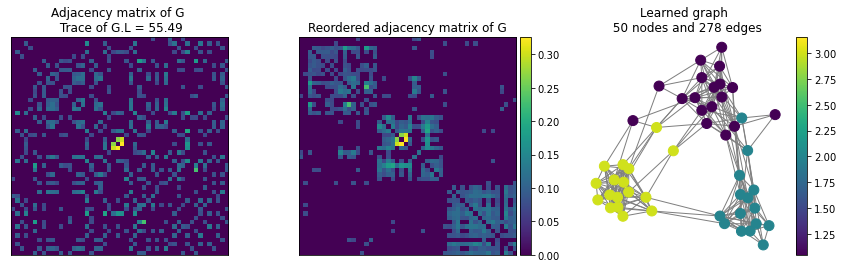

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

adj = ax[0].matshow(G.W.todense())

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(adj, cax, orientation = 'vertical')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].matshow(new_W)
ax[1].set_xticks([])
ax[1].set_yticks([])

G.plot_signal(clf, ax = ax[2], vertex_size = 100)
ax[2].axis('off')

ax[0].set_title(f'Adjacency matrix of G \n Trace of G.L = %s' % (np.round(np.trace(G.L.todense()), 2)))
ax[1].set_title(f'Reordered adjacency matrix of G' )
ax[2].set_title('Learned graph \n %s nodes and %s edges' % (G.N, G.Ne))


plt.show() #str purple agi blue/green int yellow

In [17]:
ix = np.where(G.W.todense() == np.max(G.W.todense()))

print('%s and %s are the most \'similar\' heros'%(heros[ix[0][0]], heros[ix[0][1]]))

Monkey King and Naga Siren are the most 'similar' heros


In [18]:
wrong_neighbors = {h : len([n for n in neighbors[h] if attributes[get_index(h)] != attributes[get_index(n)]]) for h in heros}

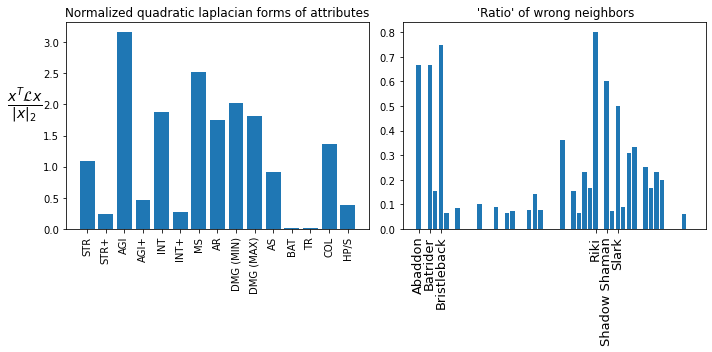

In [19]:
cs = [dataset[attr].values @ (norm_d @ G.L @ norm_d) @ dataset[attr].values / (np.linalg.norm(dataset[attr].values)) for attr in columns_to_consider]
rs = np.array([ns for ns in wrong_neighbors.values()]) * 1 / np.array([len(ns) for ns in neighbors.values()])
tol = 0.4
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].bar(np.arange(0, len(cs), 1), cs)
ax[0].set_xticks(np.arange(0, len(cs), 1))
ax[0].set_xticklabels(columns_to_consider, rotation = 90)
ax[0].set_ylabel(r'$\frac{x^T \mathcal{L} x}{\| x \|_2}$     ', fontsize = 20, rotation = 0)
ax[0].set_title('Normalized quadratic laplacian forms of attributes')

ax[1].bar(np.arange(0, len(heros), 1), rs)
ax[1].set_xticks(np.arange(0, len(heros), 1)[rs > tol])
ax[1].set_xticklabels(np.array(heros)[rs > tol], rotation = 90, fontsize = 13)
ax[1].set_title(' \'Ratio\' of wrong neighbors')
plt.tight_layout()
plt.show()

In [20]:
%matplotlib notebook

<IPython.core.display.Javascript object>


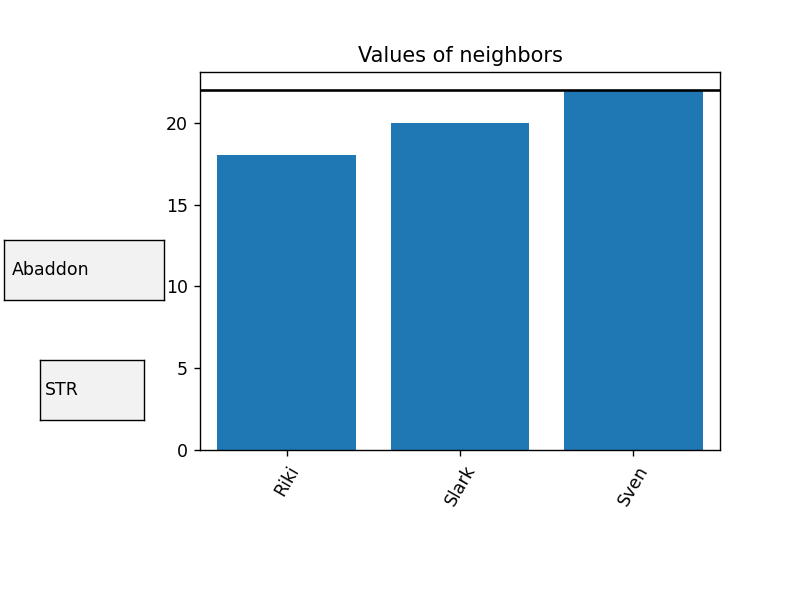

In [21]:
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)

ax.bar(np.arange(0, len(neighbors[vertice_labels[0]]), 1), 
            [dataset['STR'].values[get_index(ni)] for ni in neighbors[vertice_labels[0]]])
ax.plot([-1, len(neighbors[vertice_labels[0]]) + 1], 
        [dataset['STR'].values[0], dataset['STR'].values[0]], color = 'black')

ax.set_xticks(np.arange(0, len(neighbors[vertice_labels[0]]), 1))
ax.set_xticklabels(labels = neighbors[vertice_labels[0]], rotation = 60)
ax.set_xlim(-0.5, len(neighbors[vertice_labels[0]]) - 0.5)
ax.set_title('Values of neighbors')


rax_heros = plt.axes([0.005, 0.5, 0.2, 0.1])
textbox_heros = TextBox(rax_heros, label = '', initial='Abaddon', color='.95', hovercolor='1', label_pad=0.01,)

rax_attribute = plt.axes([0.05, 0.3, 0.13, 0.1],)
textbox_attribute = TextBox(rax_attribute, label = '', initial='STR', color='.95', hovercolor='1', label_pad=0.01,)

def update_heros(hero):
    
    ax.clear()
    t_attribute = textbox_attribute.text
    ax.set_title('Values of neighbors')
    ns = neighbors[hero]
    xs = np.arange(0, len(ns), 1)
    ys = [dataset[t_attribute].values[get_index(ni)] for ni in ns]
    ax.bar(xs, ys)
    ax.plot([-1, len(ns) + 1], [dataset[t_attribute].values[get_index(hero)], dataset[t_attribute].values[get_index(hero)]], color = 'black')
    ax.set_xticks(np.arange(0, len(neighbors[hero]), 1))
    ax.set_xticklabels(labels = neighbors[hero], rotation = 60)
    ax.set_xlim(-0.5, len(ns) - 0.5)
    plt.draw()
    
def update_attribute(attribute):
    
    ax.clear()
    ax.set_title('Values of neighbors')
    t_hero = textbox_heros.text
    ns = neighbors[t_hero]
    xs = np.arange(0, len(ns), 1)
    ys = [dataset[attribute].values[get_index(ni)] for ni in ns]
    ax.bar(xs, ys)
    ax.plot([-1, len(ns) + 1], [dataset[attribute].values[get_index(t_hero)], dataset[attribute].values[get_index(t_hero)]], color = 'black')
    ax.set_xticks(np.arange(0, len(neighbors[t_hero]), 1))
    ax.set_xticklabels(labels = neighbors[t_hero], rotation = 60)
    ax.set_xlim(-0.5, len(ns) - 0.5)
    plt.draw()
    
    
    
    
textbox_heros.on_submit(update_heros)
textbox_attribute.on_submit(update_attribute)
textbox_heros.set_val('Abaddon')
textbox_attribute.set_val('STR')
# plt.ylim(0, 30)
# plt.xlim(-0.5, len(neighbors[vertice_labels[0]]) - 0.5)
plt.show()